[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/isacki/ai3project/blob/master/svr_predict.ipynb)

# Predict COVID-19 data using SVR

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import gdown

mpl_params = {"font.size": 12, "axes.labelsize": 12, 
              "axes.titlesize": 12, "xtick.labelsize": 12,
              "ytick.labelsize": 12, "legend.fontsize": 12}
mpl.rcParams.update(mpl_params)

## Load data, differentiate between factors/effects and smooth columns if needed

In [ ]:
# Download data
infname = "owid-covid-data.csv"
work_dir = os.path.abspath("/content")
work_file = os.path.join(work_dir, infname)
data_file_link = "https://drive.google.com/uc?id=1zWIKCrWWeEGjEe5Q88i21Lu9Cet_TzdQ"
gdown.download(data_file_link, work_file, quiet=False)

In [2]:
indata = pd.read_csv(infname)

In [3]:
effects = ["total_cases", "new_cases", "total_deaths", "new_deaths",
          "total_cases_per_million", "new_cases_per_million",
          "total_deaths_per_million", "new_deaths_per_million"]
tests =["total_tests", "new_tests", "total_tests_per_thousand",
       "new_tests_per_thousand", "new_tests_smoothed",
        "new_tests_smoothed_per_thousand"]
factors = [col for col in indata.columns if col not in effects]
for factor in ("location", "date"):
    factors.remove(factor)
print("Remaining factors: ")
print(factors)

Remaining factors: 
['iso_code', 'continent', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy']


The column 'test_units' have the following unique values:

In [4]:
indata["tests_units"].drop_duplicates()

0                                  NaN
1053                   tests performed
2269                     units unclear
2408                    samples tested
5304                     people tested
14960    people tested (incl. non-PCR)
30025    units unclear (incl. non-PCR)
Name: tests_units, dtype: object

Convert date into datetime and index data.

In [5]:
indata["date"] = pd.to_datetime(indata["date"], format="%Y-%m-%d")
multi_indexed_data = indata.set_index(["date", "location"])
dates = indata["date"].drop_duplicates()
locations = indata["location"].drop_duplicates()

Available effects are:

In [6]:
for effect in effects:
    print(effect)

total_cases
new_cases
total_deaths
new_deaths
total_cases_per_million
new_cases_per_million
total_deaths_per_million
new_deaths_per_million


Smooth effects that tends to be noiser and add that to the list of effects.

In [7]:
# Parameters for moving average
n_avgs = 7
cols_to_smooth = ["new_cases", "new_deaths", "new_cases_per_million",
                 "new_deaths_per_million"]
new_cols = [col+"_smoothed" for col in cols_to_smooth]
effects += new_cols

# Create new columns
for col in new_cols:
    multi_indexed_data[col] = np.nan

# Do moving average for selected columns and store data
grps = multi_indexed_data.groupby("location")
smoothed_data = grps[cols_to_smooth].rolling(n_avgs,
                     center=True).mean().droplevel(level=0)
multi_indexed_data[new_cols] = smoothed_data

## Plot each column as a function of time for different locations

In [154]:
columns = list(multi_indexed_data.columns)

@interact
def plot_col_vs_time(loc_slider=(0,len(list(locations))-1),
                     Locations=widgets.fixed(list(locations)),
                     loc=list(locations),
                     use_slider=[True, False],
                     column=columns,
                     multi_indexed_data=widgets.fixed(multi_indexed_data)):
                     
    if use_slider:
        location = Locations[loc_slider]
    else:
        location = loc

    grps = multi_indexed_data.groupby("location")
    plot_df = grps[column].get_group(location)
    y = plot_df
    x = plot_df.index.droplevel("location").drop_duplicates()

    plt.figure(figsize=(12,4))
    plt.xlabel("Date")
    formatter = mdate.DateFormatter("%Y-%m-%d")
    locator = mdate.MonthLocator()
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    plt.ylabel(column.replace("_", " ").capitalize())
    plt.title(location)
    plt.plot_date(mdate.date2num(x), y, ".-")
    plt.show()


interactive(children=(IntSlider(value=105, description='loc_slider', max=211), Dropdown(description='loc', opt…

## Differentiate between time-varying and static columns

In [10]:
sum_std = multi_indexed_data.drop(
    columns="tests_units").groupby("location").std().dropna().sum()

tvariable_columns = sum_std.index[sum_std > 0]
static_columns = sum_std.index[sum_std <= 0]
print("The time varying columns are: ")
for col in tvariable_columns:
    print(col)

print("\nThe static columns are: ")
for col in static_columns:
    print(col)

The time varying columns are: 
total_cases
new_cases
total_deaths
new_deaths
total_cases_per_million
new_cases_per_million
total_deaths_per_million
new_deaths_per_million
total_tests
new_tests
total_tests_per_thousand
new_tests_per_thousand
new_tests_smoothed
new_tests_smoothed_per_thousand
stringency_index
new_cases_smoothed
new_deaths_smoothed
new_cases_per_million_smoothed
new_deaths_per_million_smoothed

The static columns are: 
population
population_density
median_age
aged_65_older
aged_70_older
gdp_per_capita
extreme_poverty
cardiovasc_death_rate
diabetes_prevalence
female_smokers
male_smokers
handwashing_facilities
hospital_beds_per_thousand
life_expectancy


## Select the columns we want and see how many records we have left

It looks like the only time-varying data are the effects, tests and the **stringency_index**. The number of valid records with only the effects, tests and stringency_index are:

In [11]:
print(("Total number of records (date+time) with valid effects,"+
       " tests and strigency_index:"))
print(multi_indexed_data[
    effects+tests+["stringency_index"]].dropna().index.shape[0])

print(("Total number of locations of with valid effects,"+
       " tests and strigency_index:"))
print(multi_indexed_data[
    effects + tests +
    ["stringency_index"]].dropna().index.droplevel("date").drop_duplicates().shape[0])

Total number of records (date+time) with valid effects, tests and strigency_index:
8267
Total number of locations of with valid effects, tests and strigency_index:
79


Based on our NaN exploration, we should be able to include other static factors with the exception of 'extreme_poverty', 'female_smokers', 'male_smokers', and 'handwashing_facilities' without losing too many records.

In [12]:
#discard_cols = ("extreme_poverty", "female_smokers", "male_smokers",
#               "handwashing_facilities", "hospital_beds_per_thousand")

discard_cols = ("extreme_poverty", "female_smokers", "male_smokers",
               "handwashing_facilities")

chosen_static_factors = [col for col in static_columns if col not in discard_cols]
print("For these chosen static factors:")
for factor in chosen_static_factors:
    print(factor)

print(("\nTotal number of records (date+time) with valid effects, tests," +
       " strigency_index and chosen static factors:"))
print(multi_indexed_data[
    effects + tests +
    ["stringency_index"]+chosen_static_factors].dropna().index.shape[0])

print(("Total number of locations with valid effects, tests," +
       " strigency_index and chosen static factors:"))
print(multi_indexed_data[
    effects + tests + ["stringency_index"] +
    chosen_static_factors].dropna().index.droplevel("date").drop_duplicates().shape[0])

For these chosen static factors:
population
population_density
median_age
aged_65_older
aged_70_older
gdp_per_capita
cardiovasc_death_rate
diabetes_prevalence
hospital_beds_per_thousand
life_expectancy

Total number of records (date+time) with valid effects, tests, strigency_index and chosen static factors:
7666
Total number of locations with valid effects, tests, strigency_index and chosen static factors:
73


## Create an appropriate regression dataset

Create a regression DataFrame with the effects, tests, strigency_index and other chosen static factors as columns. Also, create a new column for the targeted effect that we want to predict a fixed amount of days into the future.

In [29]:
target = "new_cases_per_million"  # Target variable to predict
dt = 14  # Days into the future to predict

dropped_data = multi_indexed_data[effects + tests +
                                   ["stringency_index"] +
                                   chosen_static_factors].dropna().copy()

future_dates = dropped_data.index.droplevel("location") + pd.Timedelta(dt, "day")
dd_locations = dropped_data.index.droplevel("date")
future_mindex = pd.MultiIndex.from_tuples(
    list(zip(future_dates, dd_locations)), names=["date", "location"])
y_mindex = dropped_data.index.intersection(future_mindex)

x_dates = y_mindex.droplevel("location") - pd.Timedelta(dt, "day")
x_locations = y_mindex.droplevel("date")
x_mindex = pd.MultiIndex.from_tuples(list(zip(x_dates, x_locations)),
                                     names=["date", "location"])

dropped_data["future_"+target] = np.nan
dropped_data.loc[x_mindex,
                 "future_"+target] = dropped_data.loc[y_mindex, target].to_numpy()
regress_data = dropped_data.dropna()

regress_data.head()

,,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_cases_smoothed,new_deaths_smoothed,...,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,future_new_cases_per_million
date,location,,,,,,,,,,,,,,,,,,,,,
2020-04-15,Argentina,2432.0,160.0,105.0,7.0,53.810,3.540,2.323,0.155,97.571429,5.714286,...,16.177,31.9,11.198,7.441,18933.907,191.032,5.5,5.0,76.67,2.744
2020-04-16,Argentina,2432.0,0.0,109.0,4.0,53.810,0.000,2.412,0.089,98.714286,6.142857,...,16.177,31.9,11.198,7.441,18933.907,191.032,5.5,5.0,76.67,3.496
2020-04-17,Argentina,2560.0,128.0,115.0,6.0,56.642,2.832,2.544,0.133,103.857143,5.571429,...,16.177,31.9,11.198,7.441,18933.907,191.032,5.5,5.0,76.67,3.164
2020-04-18,Argentina,2658.0,98.0,122.0,7.0,58.811,2.168,2.699,0.155,106.857143,6.285714,...,16.177,31.9,11.198,7.441,18933.907,191.032,5.5,5.0,76.67,2.301
2020-04-19,Argentina,2828.0,170.0,132.0,10.0,62.572,3.761,2.921,0.221,100.000000,6.571429,...,16.177,31.9,11.198,7.441,18933.907,191.032,5.5,5.0,76.67,3.297


List some basic information about our regression DataFrame.

In [30]:
print("Columns in regress_data: ")
for col in regress_data.columns:
    print(col)
    
print("\nShape of regress_data: "+str(regress_data.shape))

Columns in regress_data: 
total_cases
new_cases
total_deaths
new_deaths
total_cases_per_million
new_cases_per_million
total_deaths_per_million
new_deaths_per_million
new_cases_smoothed
new_deaths_smoothed
new_cases_per_million_smoothed
new_deaths_per_million_smoothed
total_tests
new_tests
total_tests_per_thousand
new_tests_per_thousand
new_tests_smoothed
new_tests_smoothed_per_thousand
stringency_index
population
population_density
median_age
aged_65_older
aged_70_older
gdp_per_capita
cardiovasc_death_rate
diabetes_prevalence
hospital_beds_per_thousand
life_expectancy
future_new_cases_per_million

Shape of regress_data: (6338, 30)


## Preprocess regress_data

In [168]:
X = regress_data.drop(columns="future_"+target)
y = regress_data["future_"+target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)

x_scaler = MinMaxScaler()
x_scaler.fit(X_train)
X_train_scaled = pd.DataFrame(x_scaler.transform(X_train),
                              index=X_train.index,
                              columns=X_train.columns)

y_scaler = MinMaxScaler()
y_scaler.fit(np.expand_dims(y_train.to_numpy(),axis=1))
y_train_scaled = pd.DataFrame(y_scaler.transform(
    np.expand_dims(y_train.to_numpy(), axis=1)),
                           index=y_train.index)
X_train_scaled.head()

,,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_cases_smoothed,new_deaths_smoothed,...,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy
date,location,,,,,,,,,,,,,,,,,,,,,
2020-06-15,Colombia,0.018229,0.081788,0.012879,0.021375,0.030794,0.089853,0.038928,0.041480,0.044903,0.022677,...,0.036633,0.021225,0.444444,0.250994,0.210720,0.102377,0.097442,0.353459,0.110588,0.688851
2020-06-30,Estonia,0.000711,0.043249,0.000533,0.006251,0.046075,0.068643,0.061804,0.010709,0.006786,0.000000,...,0.000714,0.014400,0.809028,0.706736,0.721601,0.242857,0.382643,0.138365,0.344314,0.750318
2020-04-17,Indonesia,0.001974,0.049927,0.003832,0.011696,0.000620,0.069327,0.002154,0.012776,0.013429,0.010997,...,0.198007,0.073743,0.343750,0.161166,0.140647,0.084489,0.572217,0.283019,0.058039,0.452734
2020-05-16,Zimbabwe,0.000015,0.043337,0.000031,0.006251,0.000087,0.068809,0.000320,0.010709,0.006794,0.000000,...,0.010526,0.020452,0.006944,0.064775,0.075472,0.004069,0.496170,0.000000,0.109804,0.019076
2020-06-27,Paraguay,0.000612,0.045745,0.000100,0.006251,0.007379,0.078441,0.002166,0.010709,0.009048,0.000158,...,0.004922,0.007214,0.246528,0.202046,0.184060,0.064042,0.260073,0.405660,0.078431,0.559983


## Compute mutual information of the columns against the target

In [169]:
mi = mutual_info_regression(X_train_scaled, y_train_scaled.squeeze(),
                            discrete_features=False,
                            random_state=1)
mi_series = pd.Series(mi, index=X_train_scaled.columns)
mi_series.sort_values(ascending=False, inplace=True)

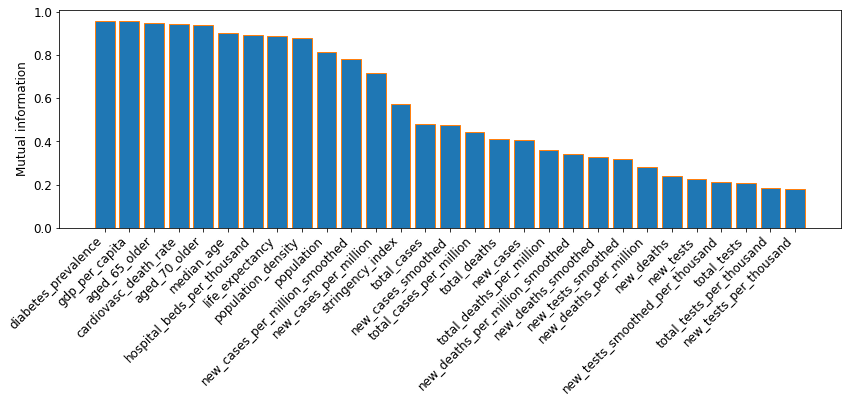

In [170]:
plt.figure(figsize=(14,4))
plt.ylabel("Mutual information")
plt.xticks(np.arange(len(mi_series.index)), list(mi_series.index),
          rotation=45, ha="right")
plt.bar(np.arange(0,len(mi_series.index)), mi_series, edgecolor="C1")
plt.show()

## Compute F-score of the columns against the target

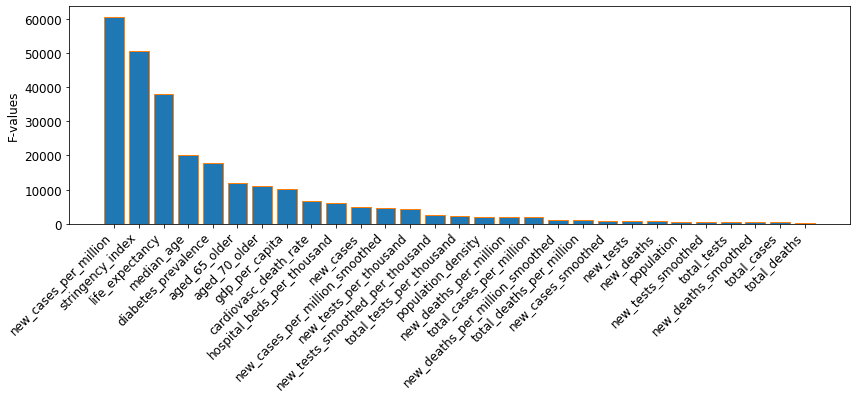

In [171]:
f_values, _ = f_regression(X_train_scaled, y_train_scaled.squeeze(),
                           center=False)
f_series = pd.Series(f_values, index=X_train_scaled.columns)
f_series.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(14,4))
plt.ylabel("F-values")
plt.xticks(np.arange(len(f_series.index)), list(f_series.index),
          rotation=45, ha="right")
plt.bar(np.arange(0,len(f_series.index)), f_series, edgecolor="C1")
plt.show()

It is fascinating to note that the the F-test, which cannot capture non-linear dependencies, give a very different result from the mutual information that can.

## Select columns using F-score and perform regression

In [172]:
# Decide which columns to use for fitting
print("Fitting with feature selection via F-score...")
fit_columns = f_series.index[0:7]
X_train_fit = X_train_scaled[fit_columns]

# Fit to training data and compute R^2 score
svr = SVR(C=20., epsilon=0.005, kernel="rbf")
svr.fit(X_train_fit, y_train_scaled.squeeze())
print("Training R^2 score: {:.3f}".format(
    svr.score(X_train_fit, y_train_scaled.squeeze())))

# Predict test data and compute R^2 score
X_test_scaled = pd.DataFrame(x_scaler.transform(X_test),
                              index=X_test.index,
                              columns=X_test.columns)

y_test_scaled = pd.DataFrame(y_scaler.transform(
    np.expand_dims(y_test.to_numpy(), axis=1)),
                           index=y_test.index)

X_test_fit = X_test_scaled[fit_columns]
print("Test R^2 score: {:.3f}".format(
    svr.score(X_test_fit, y_test_scaled.squeeze())))

Fitting with feature selection via F-score...
Training R^2 score: 0.690
Test R^2 score: 0.815


## Select columns using mutual information and perform regression

In [173]:
# Decide which columns to use for fitting
print("Fitting with feature selection via mutual information...")
fit_columns = mi_series.index[mi_series > 0.5].drop("new_cases_per_million")
X_train_fit = X_train_scaled[fit_columns]

# Fit to training data and compute R^2 score
mi_svr = SVR(C=20., epsilon=0.005, kernel="rbf")
mi_svr.fit(X_train_fit, y_train_scaled.squeeze())
print("Training R^2 score: {:.3f}".format(
    mi_svr.score(X_train_fit, y_train_scaled.squeeze())))

# Predict test data and compute R^2 score
X_test_scaled = pd.DataFrame(x_scaler.transform(X_test),
                              index=X_test.index,
                              columns=X_test.columns)

y_test_scaled = pd.DataFrame(y_scaler.transform(
    np.expand_dims(y_test.to_numpy(), axis=1)),
                           index=y_test.index)

X_test_fit = X_test_scaled[fit_columns]
print("Test R^2 score: {:.3f}".format(
    mi_svr.score(X_test_fit, y_test_scaled.squeeze())))

Fitting with feature selection via mutual information...
Training R^2 score: 0.733
Test R^2 score: 0.862


In [174]:
mi_columns = mi_series.index[mi_series > 0.5].drop("new_cases_per_million")
print("Columns used in the fit above: ")
for col in mi_columns:
    print("\t"+col)

Columns used in the fit above: 
	diabetes_prevalence
	gdp_per_capita
	aged_65_older
	cardiovasc_death_rate
	aged_70_older
	median_age
	hospital_beds_per_thousand
	life_expectancy
	population_density
	population
	new_cases_per_million_smoothed
	stringency_index


## Select columns using PCA and perform regression

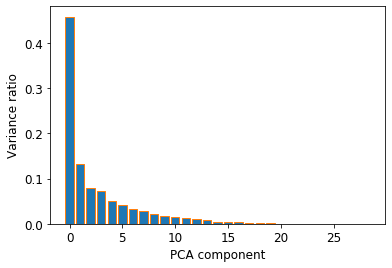

In [175]:
pca = PCA(random_state=2)
pca.fit(X_train_scaled)
var_ratio = pca.explained_variance_ratio_

plt.figure()
plt.xlabel("PCA component")
plt.ylabel("Variance ratio")
plt.bar(np.arange(len(var_ratio)), var_ratio, edgecolor="C1")
plt.show()

In [176]:
# Fit to training data and compute R^2 score
pca2 = PCA(n_components=4, random_state=2)
X_train_pca = pca2.fit_transform(X_train_scaled)
print("Fitting with feature selection via PCA...")

# Train
svr_pca = SVR(C=20., epsilon=0.005, kernel="rbf")
svr_pca.fit(X_train_pca, y_train_scaled.squeeze())
print("Training R^2 score: {:.3f}".format(
    svr_pca.score(X_train_pca, y_train_scaled.squeeze())))

# Fit
X_test_pca = pca2.transform(X_test_scaled)
print("Testing R^2 score: {:.3f}".format(
    svr_pca.score(X_test_pca, y_test_scaled.squeeze())))

Fitting with feature selection via PCA...
Training R^2 score: 0.696
Testing R^2 score: 0.812


## Compute test score for each location and print the ten best locations

In [177]:
X_test_loc_grps = X_test_fit.groupby("location")
y_test_loc_grps = y_test_scaled.groupby("location")
X_test_locations = X_test_fit.index.droplevel("date").drop_duplicates()

score_by_loc = pd.Series(index=X_test_locations,name="R^2 score")
for loc in X_test_locations:
    X_test_loc = X_test_loc_grps.get_group(loc)
    y_test_loc = y_test_loc_grps.get_group(loc)
    if X_test_loc.shape[0] > 1:
        score_by_loc[loc] = mi_svr.score(X_test_loc, y_test_loc.squeeze())

In [178]:
score_by_loc.sort_values(inplace=True, ascending=False)
score_by_loc.head(10)

location
South Africa      0.970473
Bolivia           0.898364
Colombia          0.889367
Russia            0.842987
Luxembourg        0.836608
United Kingdom    0.804370
El Salvador       0.790816
Costa Rica        0.764424
Mexico            0.737736
Israel            0.731092
Name: R^2 score, dtype: float64

## Plot the $R^2$ scores for all locations with a positive score

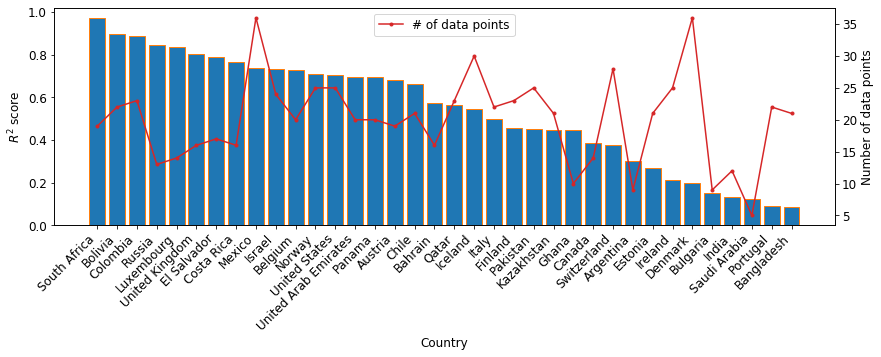

In [179]:
plot_index1 = score_by_loc.index[score_by_loc > 0]
avail_dates = X_test_loc_grps[X_test_fit.columns[0]].count()

fig, ax1 = plt.subplots(figsize=(14,4))
ax2 = ax1.twinx()
ax1.set_xlabel("Country")
ax1.set_ylabel("$R^2$ score")
ax1.set_xticks(np.arange(len(plot_index1)))
xtick_labels = ax1.set_xticklabels(plot_index1.to_numpy(), rotation=45, 
                                   ha="right")
ax1.bar(np.arange(len(plot_index1)), score_by_loc[plot_index1],
        edgecolor='C1')
ax2.set_ylabel("Number of data points")
ax2.plot(np.arange(len(plot_index1)), avail_dates[plot_index1], '.-',
        label="# of data points", color="C3")
ax2.legend(loc="upper center")
plt.show()

## Plot the $R^2$ scores for all locations with a negative score

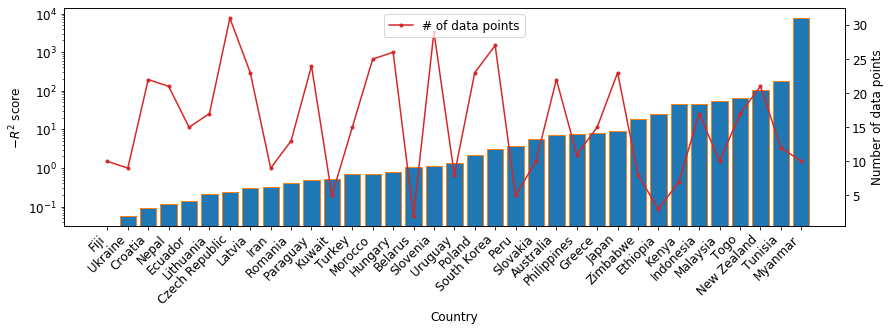

In [180]:
plot_index2 = score_by_loc.index[score_by_loc <= 0]
avail_dates = X_test_loc_grps[X_test_fit.columns[0]].count()

fig, ax1 = plt.subplots(figsize=(14,4))
ax2 = ax1.twinx()
ax1.set_xlabel("Country")
ax1.set_ylabel("$-R^2$ score")
ax1.set_xticks(np.arange(len(plot_index2)))
xtick_labels = ax1.set_xticklabels(plot_index2.to_numpy(), rotation=45, 
                                   ha="right")
ax1.bar(np.arange(len(plot_index2)), np.abs(score_by_loc[plot_index2]),
        edgecolor='C1', log=True)
ax2.set_ylabel("Number of data points")
ax2.plot(np.arange(len(plot_index2)), avail_dates[plot_index2], '.-',
        label="# of data points", color="C3")
ax2.legend(loc="upper center")
plt.show()

## Plot predicted values versus actual values

In [181]:

@interact
def plot_fit_by_loc(location=score_by_loc.index.to_numpy()):
    
    loc = location
    X_test_loc = X_test_loc_grps.get_group(loc)

    # Get original data for the dates of interest
    tmax = X_test_loc.index.droplevel("location").max() + pd.Timedelta(dt, "day")
    tmin = X_test_loc.index.droplevel("location").min()
    loc_data = multi_indexed_data.groupby("location").get_group(loc)
    tindex = loc_data.index.droplevel("location")

    mask = np.logical_and(tindex >= tmin, tindex <= tmax)
    act_data = loc_data.loc[(mask, loc), target]

    # Fit data
    y_test_loc = mi_svr.predict(X_test_loc)
    y_test_loc_rescaled = y_scaler.inverse_transform(
        np.expand_dims(y_test_loc, 1))
    predict_data = pd.Series(index=X_test_loc.index.droplevel("location"),
                             data=y_test_loc_rescaled.squeeze())
    predict_data.sort_index(inplace=True)
    predict_data.index = predict_data.index + pd.Timedelta(dt, "day")

    # Plot
    plt.figure(figsize=(8,4))
    plt.xlabel("Date")
    formatter = mdate.DateFormatter("%Y-%m-%d")
    locator = mdate.MonthLocator()
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    plt.ylabel(target.replace("_", " ").capitalize())
    plt.title("Prediction for " + loc)
    plt.plot_date(act_data.index.droplevel("location"), act_data, ".-", 
                  label="Actual")
    plt.plot_date(predict_data.index, predict_data, "x--", label="Prediction")
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='location', options=('South Africa', 'Bolivia', 'Colombia', 'Russia…

It appears that the fit tends to do badly for locations with very little new cases per million. In a sense, this is not too surprising because when the new cases per million is a small number, the data is extremely noisy and SVR would naturally have a hard time fitting to it.